In [ ]:
from google.colab import drive
import os
# Démonter Google Drive si monté
if os.path.ismount('/content/drive'):
    drive.flush_and_unmount()
    print("Google Drive démonté.")


Google Drive démonté.


In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# # Installer les modules

In [ ]:
!pip install rasterio
!pip install imagecodecs tifffile
!pip install shapely fiona
!pip install affine
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 58.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 33.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=361374e65a8251db9a9267832fe340fb9153e5b99cc0c5e35fee405716ae7619
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-non

# MODEL UNET ARCHITECTURE EN PYTORCH

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


code model marche

# PREPARATION DES DONNEES ET CREATION DU MODEL


In [ ]:
model.eval()

UNetWithDropout(
  (base_model): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            48, 12, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            12, 48, kernel_size=(1, 1), stride=(1, 1)
            (static_padd

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:01<00:00, 41.8MB/s]


Fold 1/5
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000131.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000230.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000129.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000233.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000287.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/0000000005.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /con

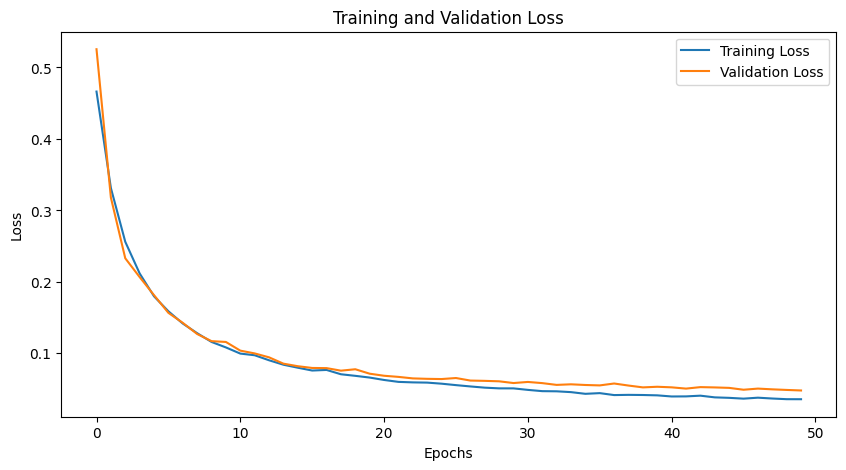

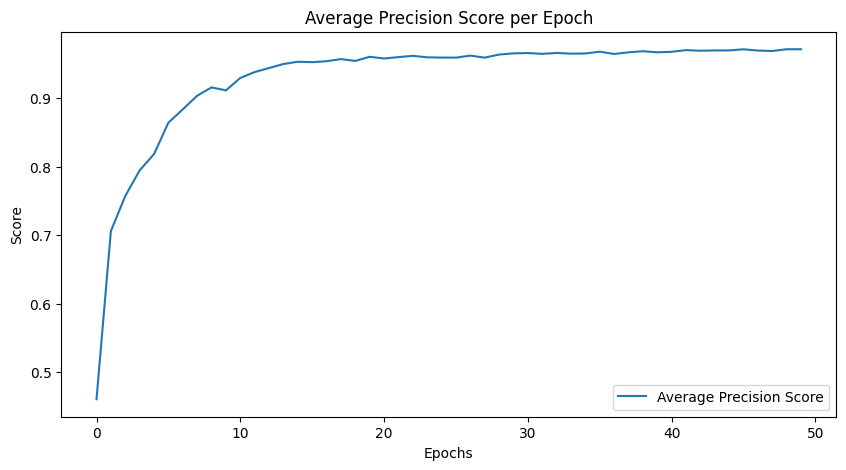

Fold 2/5
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000126.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000230.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/0000000005.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000131.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000129.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000287.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /con

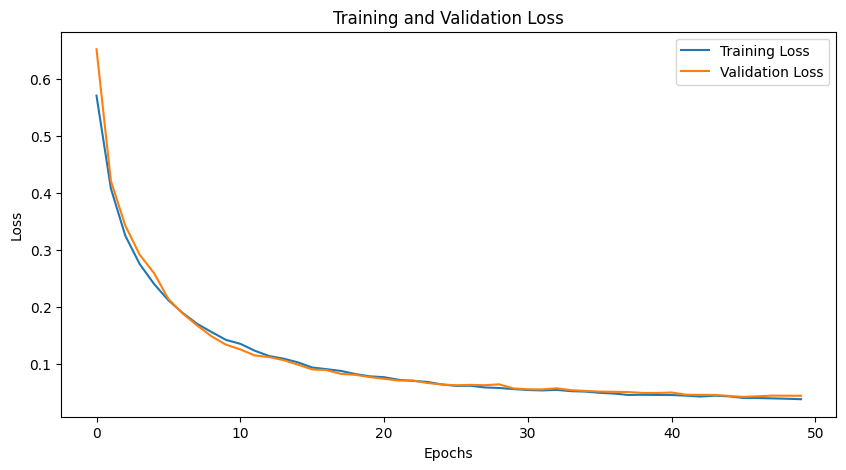

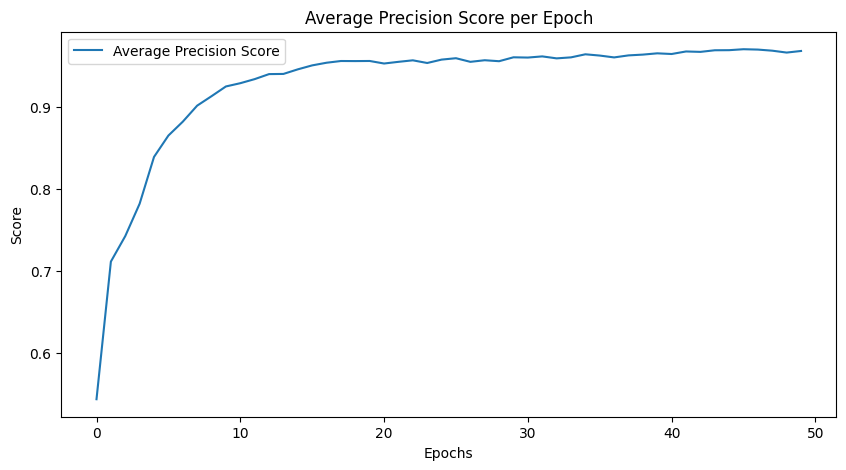

Fold 3/5
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000230.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000128.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000290.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000129.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000287.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000233.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /cont

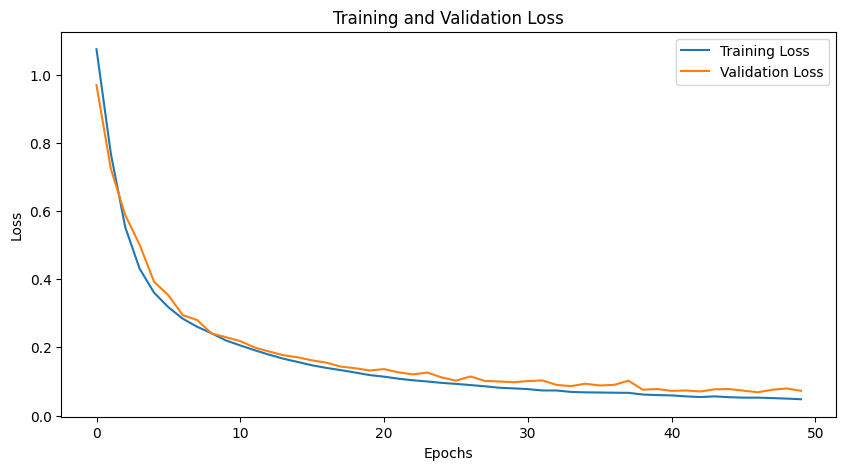

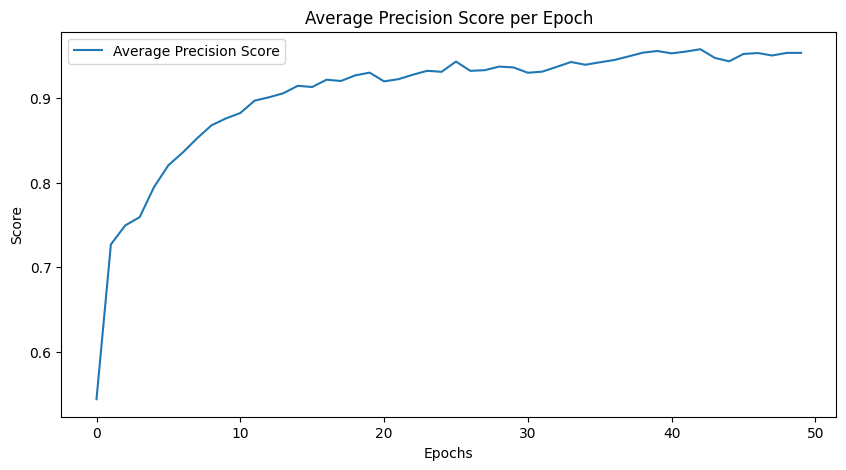

Fold 4/5
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000233.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000290.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/0000000005.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000128.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000126.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000287.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /con

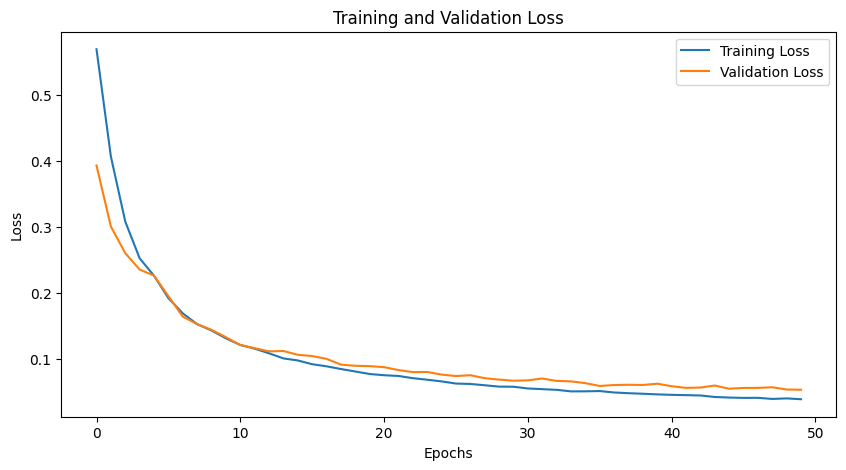

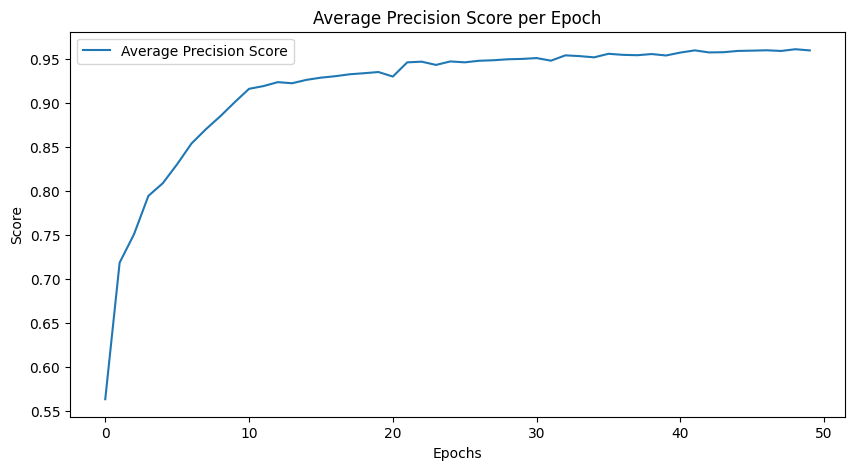

Fold 5/5
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000287.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000126.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000233.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000230.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000128.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /content/drive/MyDrive/building_detect_1/data_5/labels/Building/000000129.tif. Utilisation du premier canal uniquement.
Masque avec plusieurs canaux trouvé : /cont

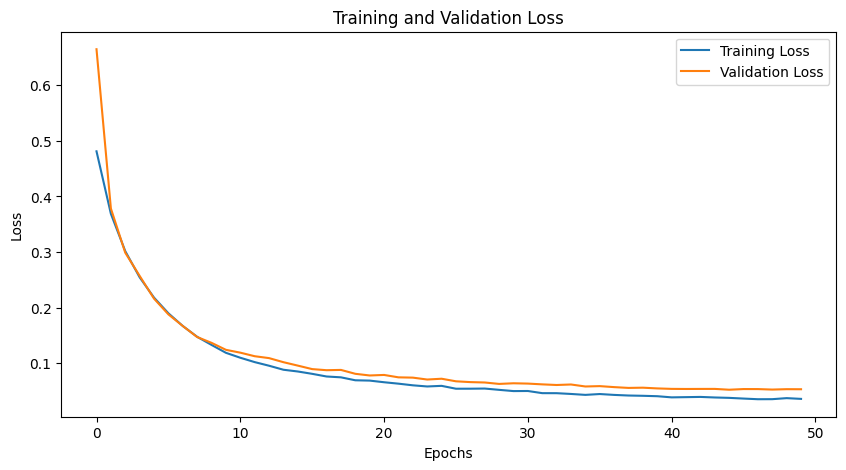

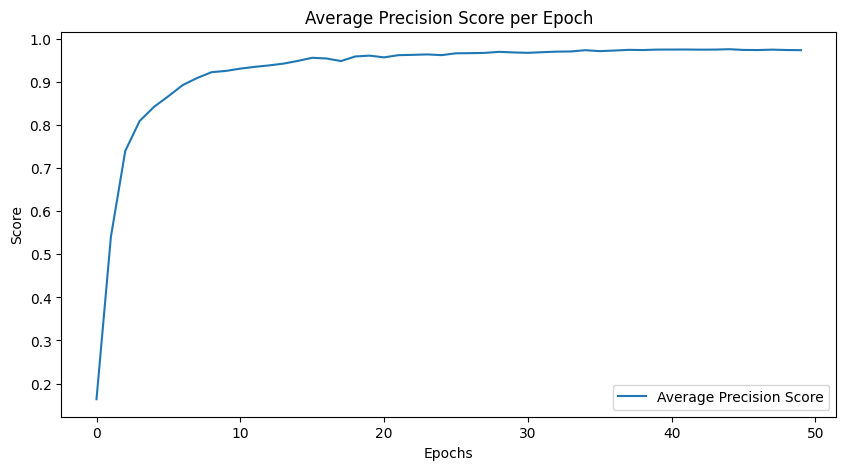

In [ ]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, Dataset
from skimage import io, transform as sk_transform
import torchvision.transforms as transforms
import numpy as np
import random
from sklearn.metrics import average_precision_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Définir le chemin de base des données
base_path = '/content/drive/MyDrive/building_detect_1/data_5'

# Fonction pour obtenir les fichiers existants et triés
def get_sorted_files(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif')]
    files.sort()  # Trier les fichiers par nom
    return files

# Chargement des images et des masques depuis un seul répertoire
images_path = os.path.join(base_path, 'images')
masks_path = os.path.join(base_path, 'labels/Building')

image_files = get_sorted_files(images_path)
mask_files = get_sorted_files(masks_path)

# Vérification de la correspondance entre le nombre d'images et de masques
assert len(image_files) == len(mask_files), "Le nombre d'images et de masques doit être égal."

# Mélanger les fichiers de manière synchrone
combined = list(zip(image_files, mask_files))
random.shuffle(combined)
image_files[:], mask_files[:] = zip(*combined)

# Transformations de base
transform = transforms.Compose([
    transforms.ToTensor()
])

# Définir les transformations d'augmentation
class Augmentation:
    def __init__(self, flip_vert=False, flip_horiz=False, rotate=False, brightness=(0.9, 1.0), contrast=(0.9, 1.0)):
        self.flip_vert = flip_vert
        self.flip_horiz = flip_horiz
        self.rotate = rotate
        self.brightness = brightness
        self.contrast = contrast

    def __call__(self, image, mask):
        # Flip vertical
        if self.flip_vert and random.random() > 0.5:
            image = np.flipud(image).copy()
            mask = np.flipud(mask).copy()

        # Flip horizontal
        if self.flip_horiz and random.random() > 0.5:
            image = np.fliplr(image).copy()
            mask = np.fliplr(mask).copy()

        # Rotation
        if self.rotate:
            angle = random.choice([0, 90, 180, 270])
            image = np.rot90(image, k=angle // 90).copy()
            mask = np.rot90(mask, k=angle // 90).copy()

        # Brightness adjustment
        if self.brightness != (1.0, 1.0):
            factor = random.uniform(*self.brightness)
            image = np.clip(image * factor, 0, 1)

        # Contrast adjustment
        if self.contrast != (0.9, 1.0):
            factor = random.uniform(*self.contrast)
            mean = np.mean(image, axis=(0, 1), keepdims=True)
            image = np.clip((image - mean) * factor + mean, 0, 1)

        return image, mask

# Définir la classe de dataset avec augmentations
class BuildingDataset(Dataset):
    def __init__(self, image_files, mask_files, transform=None, augmentation=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform
        self.augmentation = augmentation

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        mask_path = self.mask_files[idx]

        image = io.imread(image_path)
        mask = io.imread(mask_path)

        # Vérification des masques
        if mask.ndim == 3:
            print(f"Masque avec plusieurs canaux trouvé : {mask_path}. Utilisation du premier canal uniquement.")
            mask = mask[:, :, 0]  # Prendre le premier canal si le masque a plusieurs canaux

        # Assurez-vous que le masque est binaire
        mask = (mask > 0).astype(np.float32)

        # Redimensionner l'image et le masque à 256x256
        image = sk_transform.resize(image, (256, 256), mode='reflect', anti_aliasing=True)
        mask = sk_transform.resize(mask, (256, 256), mode='reflect', anti_aliasing=True, order=0)

        # Convertir en float32
        image = image.astype(np.float32)
        mask = mask.astype(np.float32)

        # Appliquer les augmentations de données
        if self.augmentation:
            image, mask = self.augmentation(image, mask)

        # Appliquer les transformations
        if self.transform:
            image = self.transform(image)
            mask = torch.from_numpy(mask).unsqueeze(0)  # Ajouter une dimension pour le canal

        return image, mask

# Créer un objet d'augmentation avec les paramètres souhaités
aug_transforms = Augmentation(
    flip_vert=True,
    flip_horiz=True,
    rotate=True,
    brightness=(0.7, 1.2),
    contrast=(0.7, 1.2)
)

# Assurez-vous que le modèle est sur le bon appareil
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Classe UNet modifiée pour inclure le Dropout
class UNetWithDropout(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(UNetWithDropout, self).__init__()
        # Initialiser le modèle U-Net de base
        self.base_model = smp.Unet('efficientnet-b4', encoder_weights='imagenet', classes=1, activation=None)

        # Ajouter des couches de Dropout après certains blocs de convolution
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        # Passer les données à travers le modèle U-Net de base
        features = self.base_model.encoder(x)  # L'encodeur produit une liste de tenseurs (features)

        # Appliquer le dropout uniquement à la dernière sortie (ou une autre sortie spécifique)
        features[-1] = self.dropout(features[-1])

        # Passer ensuite les features modifiées au décodeur
        decoder_output = self.base_model.decoder(*features)

        # Passer ensuite la sortie du décodeur par la tête de segmentation
        x = self.base_model.segmentation_head(decoder_output)
        return x

# Initialiser le modèle U-Net avec Dropout
model = UNetWithDropout(dropout_prob=0.4)
model = model.to(device)

# Fonction d'entraînement avec sauvegarde du modèle
def train_model(model, train_loader, val_loader, num_epochs=100, save_path='/content/drive/MyDrive/building_detect_1/models/best_model_with_dropout.pth'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    precision_scores = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        all_targets = []
        all_outputs = []
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                all_outputs.append(outputs.sigmoid().cpu().numpy().flatten())
                all_targets.append(masks.cpu().numpy().flatten())

        # Calculer la perte moyenne sur les lots d'entraînement et de validation
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Calculer le average precision score
        all_outputs = np.concatenate(all_outputs)
        all_targets = np.concatenate(all_targets)
        precision = average_precision_score(all_targets, all_outputs)
        precision_scores.append(precision)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Average Precision: {precision:.4f}')

        # Sauvegarder le modèle si la perte de validation est meilleure
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f'Modèle sauvegardé à l\'epoch {epoch+1} avec une perte de validation de {val_loss:.4f}')

    # Plot des courbes de perte
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot des scores de précision moyenne
    plt.figure(figsize=(10, 5))
    plt.plot(precision_scores, label='Average Precision Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Average Precision Score per Epoch')
    plt.show()

# Appliquer le K-Fold Cross Validation
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lancer le K-Fold Cross Validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(image_files)):
    print(f'Fold {fold+1}/{k_folds}')

    # Créer les ensembles d'entraînement et de validation
    train_images = [image_files[i] for i in train_idx]
    train_masks = [mask_files[i] for i in train_idx]
    val_images = [image_files[i] for i in val_idx]
    val_masks = [mask_files[i] for i in val_idx]

    # Créer les datasets et les dataloaders
    train_dataset = BuildingDataset(image_files=train_images, mask_files=train_masks, transform=transform, augmentation=aug_transforms)
    val_dataset = BuildingDataset(image_files=val_images, mask_files=val_masks, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Initialiser un nouveau modèle pour chaque fold
    model = UNetWithDropout(dropout_prob=0.5)
    model = model.to(device)

    # Vérifier que les ensembles d'entraînement et de validation ne sont pas vides
    if len(train_dataset) > 0 and len(val_dataset) > 0:
        train_model(model, train_loader, val_loader, num_epochs=50)  # Vous pouvez ajuster le nombre d'époques si nécessaire
    else:
        print("Les ensembles d'entraînement ou de validation sont vides. Veuillez vérifier les chemins d'accès aux fichiers.")


# Appliquer le model sur les images ciblées (images et masques)

In [ ]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io, transform as sk_transform

# Fonction pour charger une image depuis un chemin
def load_image(image_path):
    image = io.imread(image_path)
    # Vérifier si l'image est en niveaux de gris
    if image.ndim == 2:  # Si l'image est en niveaux de gris
        image = np.stack([image] * 3, axis=-1)  # Convertir en RGB en dupliquant le canal
    elif image.shape[-1] == 4:  # Si l'image a un canal alpha
        image = image[:, :, :3]  # Garder uniquement les trois premiers canaux (R, G, B)
    elif image.shape[-1] != 3:
        raise ValueError(f"L'image {image_path} a {image.shape[-1]} canaux, mais le modèle en attend 3.")
    image = sk_transform.resize(image, (256, 256), mode='reflect', anti_aliasing=True)
    image = image.astype(np.float32)
    return torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)

# Fonction pour enregistrer l'image prédite
def save_prediction(image, output_refined, save_path):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
    plt.title('Image Satellite')

    plt.subplot(1, 2, 2)
    plt.imshow(output_refined, cmap='gray')
    plt.title('Prédiction Segmentée')

    plt.savefig(save_path)
    plt.close()

# Répertoire des images de test
test_images_path = "/content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022"
test_image_files = [os.path.join(test_images_path, f) for f in os.listdir(test_images_path) if f.endswith('.tif')]

# Répertoire pour enregistrer les résultats
results_dir = "/content/drive/MyDrive/building_detect_1/data_project/predictions"
os.makedirs(results_dir, exist_ok=True)

# Appliquer le modèle sur chaque image de test
model.eval()
threshold = 0.2  # Ajustez le seuil si nécessaire

for image_path in test_image_files:
    # Charger l'image
    image = load_image(image_path).to(device)

    # Faire la prédiction
    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output).squeeze().cpu().numpy()

    # Appliquer le seuil
    output_binary = (output > threshold).astype(np.uint8)

    # Affiner les bords
    output_refined = refine_edges(output_binary)

    # Enregistrer le résultat
    save_path = os.path.join(results_dir, os.path.basename(image_path))
    save_prediction(image, output_refined, save_path)

    print(f"Prédiction sauvegardée pour {image_path} à {save_path}")


Prédiction sauvegardée pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000002.tif à /content/drive/MyDrive/building_detect_1/data_project/predictions/000000002.tif
Prédiction sauvegardée pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000001.tif à /content/drive/MyDrive/building_detect_1/data_project/predictions/000000001.tif
Prédiction sauvegardée pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000015.tif à /content/drive/MyDrive/building_detect_1/data_project/predictions/000000015.tif
Prédiction sauvegardée pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000010.tif à /content/drive/MyDrive/building_detect_1/data_project/predictions/000000010.tif
Prédiction sauvegardée pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000009.tif à /content/drive/MyDrive/building_detect_1/data_project/predictions/000000009.tif
Prédiction sauvegardée po

# model test

# MODEL PREDICTION AVEC Gdal

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform as sk_transform

# Fonction pour charger une image depuis un chemin
def load_image(image_path):
    image = io.imread(image_path)
    # Vérifier si l'image est en niveaux de gris
    if image.ndim == 2:  # Si l'image est en niveaux de gris
        image = np.stack([image] * 3, axis=-1)  # Convertir en RGB en dupliquant le canal
    elif image.shape[-1] == 4:  # Si l'image a un canal alpha
        image = image[:, :, :3]  # Garder uniquement les trois premiers canaux (R, G, B)
    elif image.shape[-1] != 3:
        raise ValueError(f"L'image {image_path} a {image.shape[-1]} canaux, mais le modèle en attend 3.")
    image = sk_transform.resize(image, (256, 256), mode='reflect', anti_aliasing=True)
    image = image.astype(np.float32)
    return torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)

# Fonction pour enregistrer l'image prédite avec transparence pour le fond noir et couleurs pour les bâtiments
def save_colored_prediction(image, output_refined, save_path):
    plt.figure(figsize=(10, 10))

    # Afficher l'image satellite en arrière-plan
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy(), alpha=0.8)

    # Créer un masque de couleur pour les bâtiments
    colored_mask = np.zeros((*output_refined.shape, 3))  # Image de sortie colorée
    colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']  # Différentes couleurs pour les bâtiments
    num_colors = len(colors)

    # Assigner des couleurs différentes aux bâtiments
    for i in range(output_refined.shape[0]):
        for j in range(output_refined.shape[1]):
            if output_refined[i, j] > 0:  # Si c'est un bâtiment
                color_index = (i + j) % num_colors  # Index de couleur basé sur la position
                colored_mask[i, j] = plt.get_cmap('tab10')(color_index)[:3]

    # Afficher le masque coloré par-dessus l'image de fond
    plt.imshow(colored_mask, alpha=0.6)

    # Masquer les axes et sauvegarder l'image
    plt.axis('off')
    plt.savefig(save_path, transparent=True, bbox_inches='tight')
    plt.close()

# Répertoire des images de test
test_images_path = "/content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022"
test_image_files = [os.path.join(test_images_path, f) for f in os.listdir(test_images_path) if f.endswith('.tif')]

# Répertoire pour enregistrer les résultats
results_dir = "/content/drive/MyDrive/building_detect_1/data_project/predictions"
os.makedirs(results_dir, exist_ok=True)

# Appliquer le modèle sur chaque image de test
model.eval()
threshold = 0.2  # Ajustez le seuil si nécessaire

for image_path in test_image_files:
    # Charger l'image
    image = load_image(image_path).to(device)

    # Faire la prédiction
    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output).squeeze().cpu().numpy()

    # Appliquer le seuil
    output_binary = (output > threshold).astype(np.uint8)

    # Affiner les bords (supposons que vous avez déjà cette fonction)
    output_refined = refine_edges(output_binary)

    # Enregistrer le résultat avec transparence
    save_path = os.path.join(results_dir, os.path.basename(image_path))
    save_colored_prediction(image, output_refined, save_path)

    print(f"Prédiction sauvegardée pour {image_path} à {save_path}")


Prédiction sauvegardée pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000005.tif à /content/drive/MyDrive/building_detect_1/data_project/predictions/000000005.tif
Prédiction sauvegardée pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000001.tif à /content/drive/MyDrive/building_detect_1/data_project/predictions/000000001.tif
Prédiction sauvegardée pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000000.tif à /content/drive/MyDrive/building_detect_1/data_project/predictions/000000000.tif
Prédiction sauvegardée pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000004.tif à /content/drive/MyDrive/building_detect_1/data_project/predictions/000000004.tif
Prédiction sauvegardée pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000003.tif à /content/drive/MyDrive/building_detect_1/data_project/predictions/000000003.tif
Prédiction sauvegardée po

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform as sk_transform
from scipy.ndimage import label

# Définir l'appareil (CPU ou GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fonction pour charger une image depuis un chemin
def load_image(image_path):
    image = io.imread(image_path)
    if image.ndim == 2:  # Si l'image est en niveaux de gris
        image = np.stack([image] * 3, axis=-1)
    elif image.shape[-1] == 4:  # Si l'image a un canal alpha
        image = image[:, :, :3]
    elif image.shape[-1] != 3:
        raise ValueError(f"L'image {image_path} a {image.shape[-1]} canaux, mais le modèle en attend 3.")

    # Redimensionner l'image
    image = sk_transform.resize(image, (256, 256), mode='reflect', anti_aliasing=True)
    image = image.astype(np.float32)
    return torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)

# Fonction pour afficher les images dans Colab
def display_colored_prediction(image, output_refined):
    plt.figure(figsize=(12, 6))

    # Afficher l'image satellite en arrière-plan
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
    plt.title('Image Satellite')
    plt.axis('off')

    # Créer un masque de couleur pour chaque bâtiment
    labeled_buildings, num_features = label(output_refined)
    colored_mask = np.zeros((*output_refined.shape, 3))
    cmap = plt.get_cmap('tab10')

    for i in range(1, num_features + 1):
        mask = labeled_buildings == i
        colored_mask[mask] = cmap(i % 10)[:3]

    # Afficher le masque coloré
    plt.subplot(1, 2, 2)
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy(), alpha=0.7)
    plt.imshow(colored_mask, alpha=0.6)
    plt.title('Prédiction Segmentée avec Couleurs Uniques')
    plt.axis('off')

    plt.show()

# Répertoire des images de test
test_images_path = "/content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022"
test_image_files = [os.path.join(test_images_path, f) for f in os.listdir(test_images_path) if f.endswith('.tif')]

# Appliquer le modèle sur les 10 premières images de test
model.eval()
threshold = 0.2

for i, image_path in enumerate(test_image_files[:10]):
    # Charger l'image
    image = load_image(image_path).to(device)

    # Faire la prédiction
    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output).squeeze().cpu().numpy()

    # Appliquer le seuil
    output_binary = (output > threshold).astype(np.uint8)

    # Affiner les bords (supposons que vous avez déjà cette fonction)
    output_refined = refine_edges(output_binary)

    # Afficher les résultats dans Colab
    display_colored_prediction(image, output_refined)


# Prediction des batiment: regéneration des masks georeferencés

In [ ]:
import os
import torch
import numpy as np
import cv2
from osgeo import gdal, osr
from skimage import io, transform as sk_transform
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np

# Fonction pour affiner les bords avec la morphologie
def refine_edges_with_morphology(mask, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    gradient = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel)
    mask = cv2.erode(mask, kernel, iterations=1)
    mask = cv2.dilate(mask, kernel, iterations=1)
    refined_mask = cv2.add(mask, gradient)
    return refined_mask

# Fonction pour simplifier les contours
def simplify_contours(mask, epsilon_factor=0.02):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    simplified_mask = np.zeros_like(mask)

    for contour in contours:
        epsilon = epsilon_factor * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        cv2.drawContours(simplified_mask, [approx], -1, 255, thickness=cv2.FILLED)

    return simplified_mask

# Fonction pour combiner les deux méthodes d'affinage des bords
def refine_edges(mask):
    mask = refine_edges_with_morphology(mask, kernel_size=3)
    mask = simplify_contours(mask, epsilon_factor=0.02)
    return mask

# Fonction pour charger une image depuis un chemin
def load_image(image_path):
    image = io.imread(image_path)
    # Vérifier si l'image est en niveaux de gris
    if image.ndim == 2:  # Si l'image est en niveaux de gris
        image = np.stack([image] * 3, axis=-1)  # Convertir en RGB en dupliquant le canal
    elif image.shape[-1] == 4:  # Si l'image a un canal alpha
        image = image[:, :, :3]  # Garder uniquement les trois premiers canaux (R, G, B)
    elif image.shape[-1] != 3:
        raise ValueError(f"L'image {image_path} a {image.shape[-1]} canaux, mais le modèle en attend 3.")
    image = sk_transform.resize(image, (256, 256), mode='reflect', anti_aliasing=True)
    image = image.astype(np.float32)
    return torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)

# Fonction pour enregistrer un masque prédicté avec géoréférencement
def save_georeferenced_mask(image_path, mask, save_path):
    # Charger l'image originale avec GDAL pour obtenir les infos de géoréférencement
    dataset = gdal.Open(image_path)
    geotransform = dataset.GetGeoTransform()
    projection = dataset.GetProjection()

    # Créer un nouveau dataset pour le masque
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = mask.shape
    output_dataset = driver.Create(save_path, cols, rows, 1, gdal.GDT_Byte)

    # Appliquer le géoréférencement et la projection
    output_dataset.SetGeoTransform(geotransform)
    output_dataset.SetProjection(projection)

    # Écrire le masque dans le dataset
    output_dataset.GetRasterBand(1).WriteArray(mask)

    # Fermer le dataset
    output_dataset = None

# Répertoire des images de test
test_images_path = "/content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022"
test_image_files = [os.path.join(test_images_path, f) for f in os.listdir(test_images_path) if f.endswith('.tif')]

# Répertoire pour enregistrer les masques prédits
masks_pred_dir = "/content/drive/MyDrive/building_detect_1/data_project/predictions_masks"
os.makedirs(masks_pred_dir, exist_ok=True)

# Appliquer le modèle sur chaque image de test
model.eval()
threshold = 0.3 # Ajustez le seuil si nécessaire

for image_path in test_image_files:
    # Charger l'image
    image = load_image(image_path).to(device)

    # Faire la prédiction
    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output).squeeze().cpu().numpy()

    # Appliquer le seuil
    output_binary = (output > threshold).astype(np.uint8)

    # Optionnel: affiner les bords
    output_refined = refine_edges(output_binary)

    # Enregistrer le masque géoréférencé
    mask_save_path = os.path.join(masks_pred_dir, os.path.basename(image_path))
    save_georeferenced_mask(image_path, output_refined, mask_save_path)

    print(f"Masque géoréférencé sauvegardé pour {image_path} à {mask_save_path}")


Masque géoréférencé sauvegardé pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000002.tif à /content/drive/MyDrive/building_detect_1/data_project/predictions_masks/000000002.tif
Masque géoréférencé sauvegardé pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000001.tif à /content/drive/MyDrive/building_detect_1/data_project/predictions_masks/000000001.tif
Masque géoréférencé sauvegardé pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000006.tif à /content/drive/MyDrive/building_detect_1/data_project/predictions_masks/000000006.tif
Masque géoréférencé sauvegardé pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000005.tif à /content/drive/MyDrive/building_detect_1/data_project/predictions_masks/000000005.tif
Masque géoréférencé sauvegardé pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000004.tif à /content/drive/MyDrive/building_detect_1/

In [ ]:
import os
import torch
import numpy as np
import cv2
from osgeo import gdal
from skimage import io, transform as sk_transform
import matplotlib.pyplot as plt

# Fonction pour affiner les bords avec la morphologie
def refine_edges_with_morphology(mask, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    gradient = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel)
    mask = cv2.erode(mask, kernel, iterations=1)
    mask = cv2.dilate(mask, kernel, iterations=1)
    refined_mask = cv2.add(mask, gradient)
    return refined_mask

# Fonction pour simplifier les contours
def simplify_contours(mask, epsilon_factor=0.02):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    simplified_mask = np.zeros_like(mask)

    for contour in contours:
        epsilon = epsilon_factor * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        cv2.drawContours(simplified_mask, [approx], -1, 255, thickness=cv2.FILLED)

    return simplified_mask

# Fonction pour combiner les deux méthodes d'affinage des bords
def refine_edges(mask):
    mask = refine_edges_with_morphology(mask, kernel_size=3)
    mask = simplify_contours(mask, epsilon_factor=0.02)
    return mask

# Fonction pour charger une image depuis un chemin
def load_image(image_path):
    image = io.imread(image_path)
    # Vérifier si l'image est en niveaux de gris
    if image.ndim == 2:  # Si l'image est en niveaux de gris
        image = np.stack([image] * 3, axis=-1)  # Convertir en RGB en dupliquant le canal
    elif image.shape[-1] == 4:  # Si l'image a un canal alpha
        image = image[:, :, :3]  # Garder uniquement les trois premiers canaux (R, G, B)
    elif image.shape[-1] != 3:
        raise ValueError(f"L'image {image_path} a {image.shape[-1]} canaux, mais le modèle en attend 3.")
    image = sk_transform.resize(image, (256, 256), mode='reflect', anti_aliasing=True)
    image = image.astype(np.float32)
    return torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)

# Fonction pour enregistrer un masque prédicté avec géoréférencement
def save_georeferenced_mask(image_path, mask, save_path):
    # Charger l'image originale avec GDAL pour obtenir les infos de géoréférencement
    dataset = gdal.Open(image_path)
    geotransform = dataset.GetGeoTransform()
    projection = dataset.GetProjection()

    # Créer un nouveau dataset pour le masque
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = mask.shape
    output_dataset = driver.Create(save_path, cols, rows, 1, gdal.GDT_Byte)

    # Appliquer le géoréférencement et la projection
    output_dataset.SetGeoTransform(geotransform)
    output_dataset.SetProjection(projection)

    # Écrire le masque dans le dataset
    output_dataset.GetRasterBand(1).WriteArray(mask)

    # Fermer le dataset
    output_dataset = None

# Répertoire des images de test
test_images_path = "/content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022"
test_image_files = [os.path.join(test_images_path, f) for f in os.listdir(test_images_path) if f.endswith('.tif')]

# Répertoire pour enregistrer les masques prédits
masks_pred_dir = "/content/drive/MyDrive/building_detect_1/data_project/predictions_masks"
os.makedirs(masks_pred_dir, exist_ok=True)

# Appliquer le modèle sur chaque image de test
model.eval()
threshold = 0.1  # Ajustez le seuil si nécessaire

for image_path in test_image_files:
    # Charger l'image
    image = load_image(image_path).to(device)

    # Faire la prédiction
    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output).squeeze().cpu().numpy()

    # Appliquer le seuil
    output_binary = (output > threshold).astype(np.uint8)

    # Optionnel: affiner les bords
    output_refined = refine_edges(output_binary)

    # Enregistrer le masque géoréférencé
    mask_save_path = os.path.join(masks_pred_dir, os.path.basename(image_path))
    save_georeferenced_mask(image_path, output_refined, mask_save_path)

    print(f"Masque géoréférencé sauvegardé pour {image_path} à {mask_save_path}")


Masque géoréférencé sauvegardé pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000002.tif à /content/drive/MyDrive/building_detect_1/data_project/predictions_masks/000000002.tif
Masque géoréférencé sauvegardé pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000001.tif à /content/drive/MyDrive/building_detect_1/data_project/predictions_masks/000000001.tif
Masque géoréférencé sauvegardé pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000006.tif à /content/drive/MyDrive/building_detect_1/data_project/predictions_masks/000000006.tif
Masque géoréférencé sauvegardé pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000005.tif à /content/drive/MyDrive/building_detect_1/data_project/predictions_masks/000000005.tif
Masque géoréférencé sauvegardé pour /content/drive/MyDrive/building_detect_1/data_project/image_agnin_2022/000000004.tif à /content/drive/MyDrive/building_detect_1/

# Fusionner toutes les masques en une seule images.tif

In [ ]:
import os
from osgeo import gdal

def merge_tifs(input_dir, output_file):
    # Lister tous les fichiers TIFF dans le répertoire
    tif_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.tif')]

    # Créer un fichier VRT qui référence tous les fichiers TIFF
    vrt_options = gdal.BuildVRTOptions(resampleAlg='nearest')
    vrt = gdal.BuildVRT('/vsimem/merged.vrt', tif_files, options=vrt_options)

    # Convertir le VRT en un fichier TIFF physique
    gdal.Translate(output_file, vrt)

    # Fermer le dataset VRT
    vrt = None

# Spécifiez le répertoire contenant les fichiers TIFF et le fichier de sortie
input_directory = '/content/drive/MyDrive/building_detect_1/data_project/predictions_masks'
output_file = '/content/drive/MyDrive/building_detect_1/data_project/merged/merged_agnin.tif'

merge_tifs(input_directory, output_file)

print(f'Image fusionnée enregistrée sous {output_file}')


Image fusionnée enregistrée sous /content/drive/MyDrive/building_detect_1/data_project/merged/merged_agnin.tif


In [ ]:
from osgeo import gdal

# Chemins d'accès aux images
mask_2016_path = "/content/drive/MyDrive/building_detect_1/data_project/merged/merged_agnin_2016.tif"
mask_2024_path = "/content/drive/MyDrive/building_detect_1/data_project/merged/merged_agnin_2024.tif"
mask_2024_resampled_path = "/content/drive/MyDrive/building_detect_1/data_project/merged/resampled_agnin_2024.tif"

# Ouvrir l'image de 2016 pour obtenir la géotransformation et la projection
ds_2016 = gdal.Open(mask_2016_path)
if ds_2016 is None:
    raise RuntimeError(f"Erreur de chargement de l'image : {mask_2016_path}")

geotransform_2016 = ds_2016.GetGeoTransform()
projection_2016 = ds_2016.GetProjection()

# Fermer le dataset après extraction des informations
ds_2016 = None

# Vérifiez également le chargement du fichier 2024 avant le rééchantillonnage
ds_2024 = gdal.Open(mask_2024_path)
if ds_2024 is None:
    raise RuntimeError(f"Erreur de chargement de l'image : {mask_2024_path}")
ds_2024 = None

# Rééchantillonner l'image de 2024 pour qu'elle corresponde à l'image de 2016
result = gdal.Warp(
    mask_2024_resampled_path,    # Chemin de l'image de sortie
    mask_2024_path,              # Chemin de l'image de 2024 à rééchantillonner
    format='GTiff',              # Format de l'image de sortie
    xRes=geotransform_2016[1],   # Résolution en X de l'image de 2016
    yRes=-geotransform_2016[5],  # Résolution en Y de l'image de 2016 (doit être négative)
    dstSRS=projection_2016,      # Système de projection de l'image de 2016
    outputBounds=[               # Définir les limites de sortie pour le rééchantillonnage
        geotransform_2016[0],                            # x_min
        geotransform_2016[3] + geotransform_2016[5] * 2048,  # y_min
        geotransform_2016[0] + geotransform_2016[1] * 2048,  # x_max
        geotransform_2016[3]                             # y_max
    ],
    resampleAlg='near'           # Algorithme de rééchantillonnage (ici 'near' pour 'nearest neighbor')
)

# Vérifier si le rééchantillonnage a réussi
if result is None:
    raise RuntimeError(f"Le rééchantillonnage a échoué pour le fichier: {mask_2024_path}")
else:
    print(f"L'image de 2024 a été rééchantillonnée avec succès et enregistrée sous : {mask_2024_resampled_path}")

# Libérer la mémoire
result = None


L'image de 2024 a été rééchantillonnée avec succès et enregistrée sous : /content/drive/MyDrive/building_detect_1/data_project/merged/resampled_agnin_2024.tif


### VERIFIER LES DIMENSIONS ET LES PROJECTIONS DE NOS DEUX MASQUES

In [ ]:
from osgeo import gdal

def print_gdal_info(image_path):
    dataset = gdal.Open(image_path)
    if not dataset:
        raise FileNotFoundError(f"Impossible d'ouvrir le fichier : {image_path}")

    print(f"Information pour {image_path}:")
    print(f"Projection: {dataset.GetProjection()}")
    print(f"GeoTransform: {dataset.GetGeoTransform()}")
    print(f"Dimensions: {dataset.RasterXSize} x {dataset.RasterYSize}")
    dataset = None

print_gdal_info(mask_2016_path)
print_gdal_info(mask_2024_path)

Information pour /content/drive/MyDrive/building_detect_1/data_project/merged/merged_agnin_2016.tif:
Projection: PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]
GeoTransform: (540006.9637470946, 0.5442852335890376, 0.0, 5676253.419747908, 0.0, -0.5445644311563633)
Dimensions: 2048 x 2048
Information pour /content/drive/MyDrive/building_detect_1/data_project/merged

### RESULTAT DES NOUVEAUX BATIMENTS ENTRE 2016 ET 2024

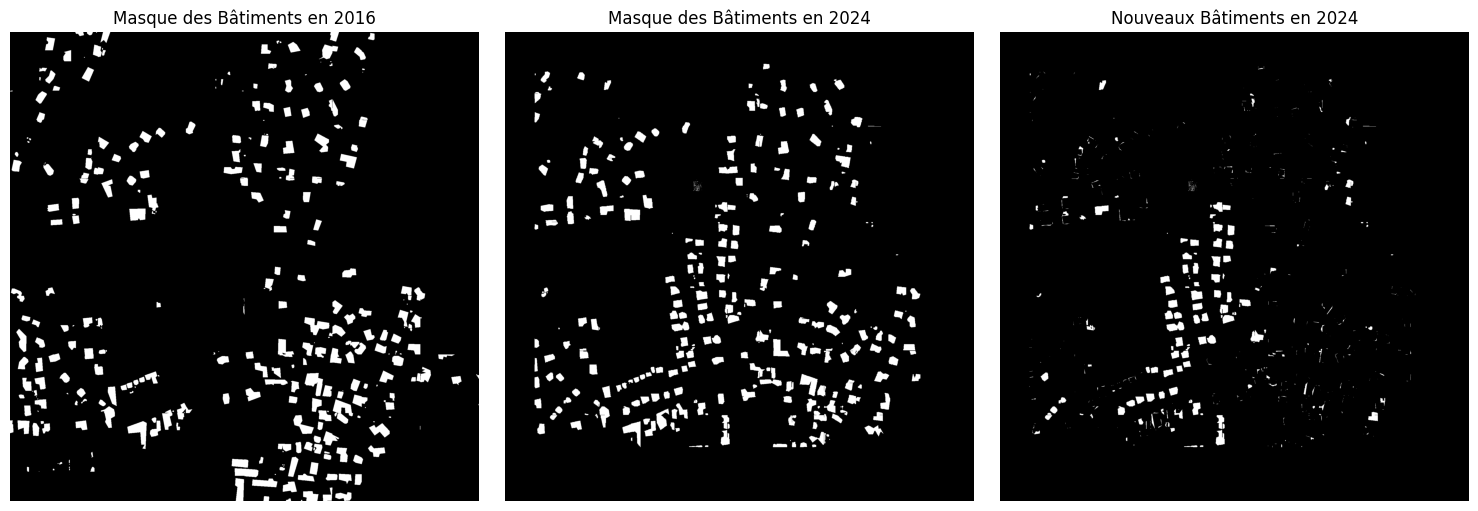

Nouveaux bâtiments sauvegardés sous : /content/drive/MyDrive/building_detect_1/data_project/merged/new_buildings_2024.tif


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

# Chemins d'accès aux masques rééchantillonnés
mask_2016_path = "/content/drive/MyDrive/building_detect_1/data_project/merged/merged_agnin_2016.tif"
mask_2024_resampled_path = "/content/drive/MyDrive/building_detect_1/data_project/merged/resampled_agnin_2024.tif"

# Charger les masques avec GDAL
ds_2016 = gdal.Open(mask_2016_path)
mask_2016 = ds_2016.ReadAsArray()

ds_2024 = gdal.Open(mask_2024_resampled_path)
mask_2024 = ds_2024.ReadAsArray()

# Fermer les datasets GDAL après utilisation
ds_2016 = None
ds_2024 = None

# Assurez-vous que les deux masques sont binaires (au cas où)
mask_2016_binary = (mask_2016 > 0).astype(np.uint8)
mask_2024_binary = (mask_2024 > 0).astype(np.uint8)

# Calculer la différence : Nouveaux bâtiments en 2024 qui n'étaient pas présents en 2016
new_buildings = np.logical_and(mask_2024_binary == 1, mask_2016_binary == 0).astype(np.uint8)

# Visualiser les masques et les différences
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(mask_2016_binary, cmap='gray')
plt.title('Masque des Bâtiments en 2016')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_2024_binary, cmap='gray')
plt.title('Masque des Bâtiments en 2024')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(new_buildings, cmap='gray')
plt.title('Nouveaux Bâtiments en 2024')
plt.axis('off')

plt.tight_layout()
plt.show()

# Sauvegarder le masque des nouveaux bâtiments si nécessaire
new_buildings_path = "/content/drive/MyDrive/building_detect_1/data_project/merged/new_buildings_2024.tif"
driver = gdal.GetDriverByName('GTiff')
output_ds = driver.Create(new_buildings_path, mask_2016_binary.shape[1], mask_2016_binary.shape[0], 1, gdal.GDT_Byte)
output_ds.SetGeoTransform(gdal.Open(mask_2016_path).GetGeoTransform())
output_ds.SetProjection(gdal.Open(mask_2016_path).GetProjection())
output_ds.GetRasterBand(1).WriteArray(new_buildings)
output_ds.FlushCache()
output_ds = None

print(f"Nouveaux bâtiments sauvegardés sous : {new_buildings_path}")


### RESULTAT DES NOUVEAUX BATIMENTS ENTRE 2016 ET 2024 EN COULEURS

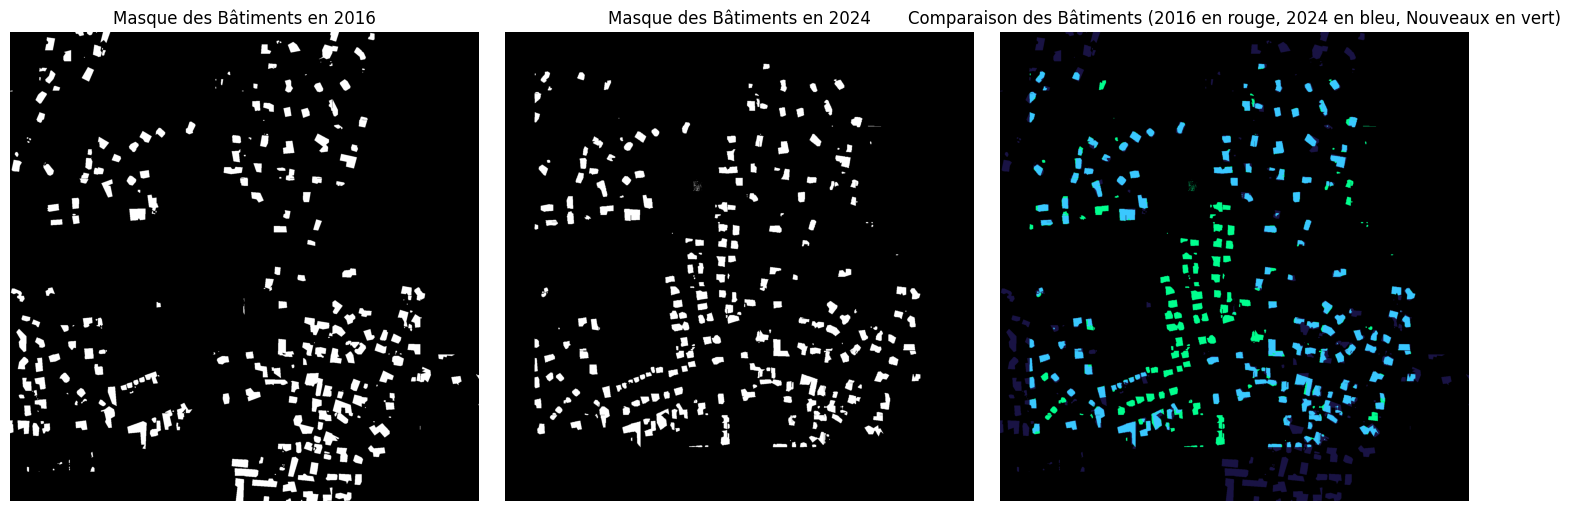

Nouveaux bâtiments sauvegardés sous : /content/drive/MyDrive/building_detect_1/data_project/merged/new_buildings_2024.tif


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

# Chemins d'accès aux masques rééchantillonnés
mask_2016_path = "/content/drive/MyDrive/building_detect_1/data_project/merged/merged_agnin_2016.tif"
mask_2024_resampled_path = "/content/drive/MyDrive/building_detect_1/data_project/merged/resampled_agnin_2024.tif"

# Charger les masques avec GDAL
ds_2016 = gdal.Open(mask_2016_path)
mask_2016 = ds_2016.ReadAsArray()

ds_2024 = gdal.Open(mask_2024_resampled_path)
mask_2024 = ds_2024.ReadAsArray()

# Fermer les datasets GDAL après utilisation
ds_2016 = None
ds_2024 = None

# Assurez-vous que les deux masques sont binaires (au cas où)
mask_2016_binary = (mask_2016 > 0).astype(np.uint8)
mask_2024_binary = (mask_2024 > 0).astype(np.uint8)

# Calculer la différence : Nouveaux bâtiments en 2024 qui n'étaient pas présents en 2016
new_buildings = np.logical_and(mask_2024_binary == 1, mask_2016_binary == 0).astype(np.uint8)

# Créer une image couleur pour visualiser les masques
# 0: fond, 1: bâtiments 2016, 2: bâtiments 2024
visualization = np.zeros((mask_2016_binary.shape[0], mask_2016_binary.shape[1], 3), dtype=np.uint8)

# Colorer les bâtiments de 2016 en rouge
visualization[mask_2016_binary == 1] = [25, 19, 68]  # Rouge

# Colorer les bâtiments de 2024 en bleu
visualization[mask_2024_binary == 1] = [58, 200, 255]  # Bleu

# Colorer les nouveaux bâtiments en vert
visualization[new_buildings == 1] = [0, 255, 142]  # Vert

# Visualiser les masques et les différences
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(mask_2016_binary, cmap='gray')
plt.title('Masque des Bâtiments en 2016')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_2024_binary, cmap='gray')
plt.title('Masque des Bâtiments en 2024')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(visualization)
plt.title('Comparaison des Bâtiments (2016 en rouge, 2024 en bleu, Nouveaux en vert)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Sauvegarder le masque des nouveaux bâtiments si nécessaire
new_buildings_path = "/content/drive/MyDrive/building_detect_1/data_project/merged/new_buildings_2024.tif"
driver = gdal.GetDriverByName('GTiff')
output_ds = driver.Create(new_buildings_path, mask_2016_binary.shape[1], mask_2016_binary.shape[0], 1, gdal.GDT_Byte)
output_ds.SetGeoTransform(gdal.Open(mask_2016_path).GetGeoTransform())
output_ds.SetProjection(gdal.Open(mask_2016_path).GetProjection())
output_ds.GetRasterBand(1).WriteArray(new_buildings)
output_ds.FlushCache()
output_ds = None

print(f"Nouveaux bâtiments sauvegardés sous : {new_buildings_path}")


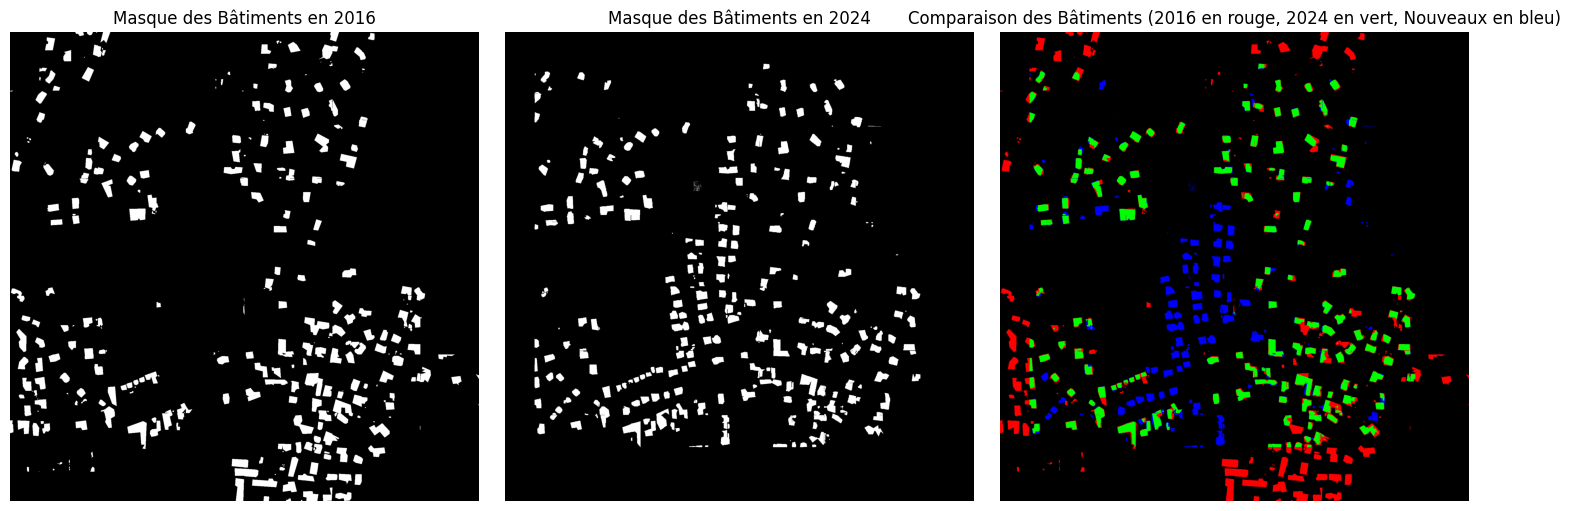

Nouveaux bâtiments sauvegardés sous : /content/drive/MyDrive/building_detect_1/data_project/merged/new_buildings_2024.tif


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

# Chemins d'accès aux masques rééchantillonnés
mask_2016_path = "/content/drive/MyDrive/building_detect_1/data_project/merged/merged_agnin_2016.tif"
mask_2024_resampled_path = "/content/drive/MyDrive/building_detect_1/data_project/merged/resampled_agnin_2024.tif"

# Charger les masques avec GDAL
ds_2016 = gdal.Open(mask_2016_path)
mask_2016 = ds_2016.ReadAsArray()

ds_2024 = gdal.Open(mask_2024_resampled_path)
mask_2024 = ds_2024.ReadAsArray()

# Fermer les datasets GDAL après utilisation
ds_2016 = None
ds_2024 = None

# Assurez-vous que les deux masques sont binaires (au cas où)
mask_2016_binary = (mask_2016 > 0).astype(np.uint8)
mask_2024_binary = (mask_2024 > 0).astype(np.uint8)

# Calculer la différence : Nouveaux bâtiments en 2024 qui n'étaient pas présents en 2016
new_buildings = np.logical_and(mask_2024_binary == 1, mask_2016_binary == 0).astype(np.uint8)

# Créer une image couleur pour visualiser les masques
# 0: fond, 1: bâtiments 2016, 2: bâtiments 2024, 3: nouveaux bâtiments
visualization = np.zeros((mask_2016_binary.shape[0], mask_2016_binary.shape[1], 3), dtype=np.uint8)

# Colorer les bâtiments de 2016 en rouge
visualization[mask_2016_binary == 1] = [255, 0, 0]  # Rouge

# Colorer les bâtiments de 2024 en vert
visualization[mask_2024_binary == 1] = [0, 255, 0]  # Vert

# Colorer les nouveaux bâtiments en bleu
visualization[new_buildings == 1] = [0, 0, 255]  # Bleu

# Visualiser les masques et les différences
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(mask_2016_binary, cmap='gray')
plt.title('Masque des Bâtiments en 2016')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_2024_binary, cmap='gray')
plt.title('Masque des Bâtiments en 2024')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(visualization)
plt.title('Comparaison des Bâtiments (2016 en rouge, 2024 en vert, Nouveaux en bleu)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Sauvegarder le masque des nouveaux bâtiments si nécessaire
new_buildings_path = "/content/drive/MyDrive/building_detect_1/data_project/merged/new_buildings_2024.tif"
driver = gdal.GetDriverByName('GTiff')
output_ds = driver.Create(new_buildings_path, mask_2016_binary.shape[1], mask_2016_binary.shape[0], 1, gdal.GDT_Byte)
output_ds.SetGeoTransform(gdal.Open(mask_2016_path).GetGeoTransform())
output_ds.SetProjection(gdal.Open(mask_2016_path).GetProjection())
output_ds.GetRasterBand(1).WriteArray(new_buildings)
output_ds.FlushCache()
output_ds = None

print(f"Nouveaux bâtiments sauvegardés sous : {new_buildings_path}")


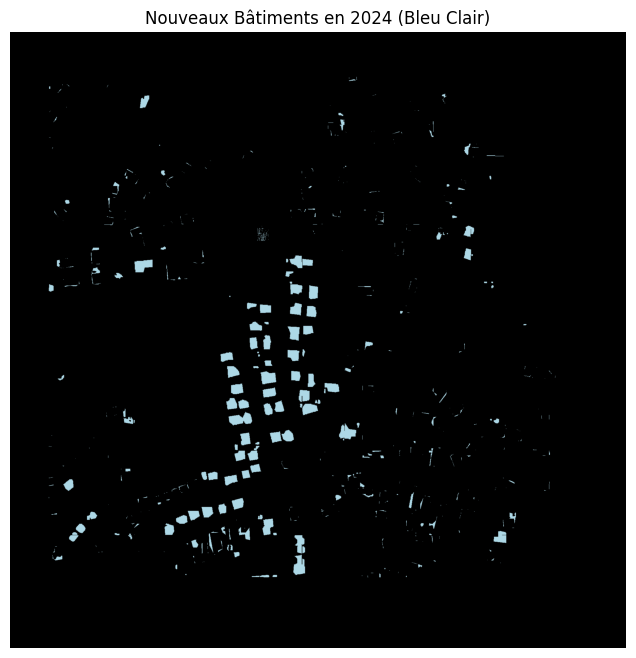

Nouveaux bâtiments sauvegardés sous : /content/drive/MyDrive/building_detect_1/data_project/merged/new_buildings_2024.tif


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

# Chemins d'accès aux masques rééchantillonnés
mask_2016_path = "/content/drive/MyDrive/building_detect_1/data_project/merged/merged_agnin_2016.tif"
mask_2024_resampled_path = "/content/drive/MyDrive/building_detect_1/data_project/merged/resampled_agnin_2024.tif"

# Charger les masques avec GDAL
ds_2016 = gdal.Open(mask_2016_path)
mask_2016 = ds_2016.ReadAsArray()

ds_2024 = gdal.Open(mask_2024_resampled_path)
mask_2024 = ds_2024.ReadAsArray()

# Fermer les datasets GDAL après utilisation
ds_2016 = None
ds_2024 = None

# Assurez-vous que les deux masques sont binaires (au cas où)
mask_2016_binary = (mask_2016 > 0).astype(np.uint8)
mask_2024_binary = (mask_2024 > 0).astype(np.uint8)

# Calculer la différence : Nouveaux bâtiments en 2024 qui n'étaient pas présents en 2016
new_buildings = np.logical_and(mask_2024_binary == 1, mask_2016_binary == 0).astype(np.uint8)

# Créer une image couleur pour visualiser les nouveaux bâtiments
# Initialiser une image RGB avec des zéros
visualization = np.zeros((mask_2016_binary.shape[0], mask_2016_binary.shape[1], 3), dtype=np.uint8)

# Colorer les nouveaux bâtiments en bleu clair (RGB: 173, 216, 230)
visualization[new_buildings == 1] = [173, 216, 230]  # Bleu clair

# Visualiser uniquement les nouveaux bâtiments
plt.figure(figsize=(8, 8))
plt.imshow(visualization)
plt.title('Nouveaux Bâtiments en 2024 (Bleu Clair)')
plt.axis('off')
plt.show()

# Sauvegarder le masque des nouveaux bâtiments si nécessaire
new_buildings_path = "/content/drive/MyDrive/building_detect_1/data_project/merged/new_buildings_2024.tif"
driver = gdal.GetDriverByName('GTiff')
output_ds = driver.Create(new_buildings_path, mask_2016_binary.shape[1], mask_2016_binary.shape[0], 1, gdal.GDT_Byte)
output_ds.SetGeoTransform(gdal.Open(mask_2016_path).GetGeoTransform())
output_ds.SetProjection(gdal.Open(mask_2016_path).GetProjection())
output_ds.GetRasterBand(1).WriteArray(new_buildings)
output_ds.FlushCache()
output_ds = None

print(f"Nouveaux bâtiments sauvegardés sous : {new_buildings_path}")


### RESULTATS DES MASQUES APPLIQUEES AVEC NOTRE MODELE

# LE RESTE DE CODE C'EST DES TESTES "A REGARDER"

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_predictions_with_threshold(model, dataset, num_samples=3, threshold=0.5):
    model.eval()
    for i in range(num_samples):
        image, mask = dataset[i]
        image = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image)
            output = torch.sigmoid(output).squeeze().cpu().numpy()

        # Appliquer le seuil
        output_binary = (output > threshold).astype(np.uint8)

        plt.figure(figsize=(15, 5))

        # Afficher l'image d'entrée
        plt.subplot(1, 3, 1)
        plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
        plt.title('Image')

        # Afficher le masque vrai
        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze().cpu().numpy(), cmap='gray')
        plt.title('Vrai Masque')

        # Afficher le masque prédit (après application du seuil)
        plt.subplot(1, 3, 3)
        plt.imshow(output_binary, cmap='gray')
        plt.title('Masque Prédit (avec seuil)')

        plt.show()

# Utilisation de la fonction pour visualiser les prédictions sur le jeu de test
visualize_predictions_with_threshold(model, test_dataset, num_samples=10, threshold=0.2)


NameError: name 'test_dataset' is not defined

In [ ]:
# Chemin où vous voulez enregistrer votre modèle
save_path = '/content/drive/MyDrive/building_detect_1/models/sara_model.pth'

# Enregistrer le state_dict du modèle
torch.save(model.state_dict(), save_path)

print(f'Modèle sauvegardé à {save_path}')

Modèle sauvegardé à /content/drive/MyDrive/building_detect_1/models/sara_model.pth


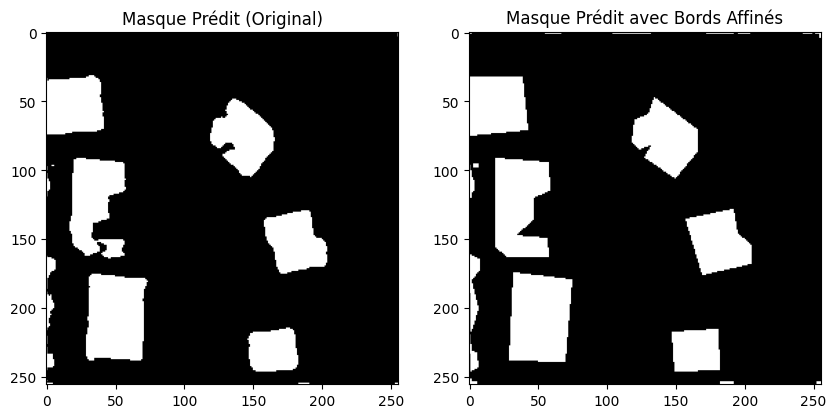

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

def refine_edges_with_morphology(mask, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    gradient = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel)
    mask = cv2.erode(mask, kernel, iterations=1)
    mask = cv2.dilate(mask, kernel, iterations=1)
    refined_mask = cv2.add(mask, gradient)
    return refined_mask

def simplify_contours(mask, epsilon_factor=0.02):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    simplified_mask = np.zeros_like(mask)

    for contour in contours:
        epsilon = epsilon_factor * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        cv2.drawContours(simplified_mask, [approx], -1, 255, thickness=cv2.FILLED)

    return simplified_mask

def refine_edges(mask):
    mask = refine_edges_with_morphology(mask, kernel_size=3)
    mask = simplify_contours(mask, epsilon_factor=0.02)
    return mask

# Supposons que vous avez déjà un modèle chargé et une image
model.eval()
image, mask = test_dataset[0]  # Remplacer 0 par l'index de l'image que vous voulez tester
image = image.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image)
    output = torch.sigmoid(output).squeeze().cpu().numpy()

# Définir le seuil
threshold = 0.1
output_binary = (output > threshold).astype(np.uint8)

# Affiner les bords
output_refined = refine_edges(output_binary)

# Afficher le résultat
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(output_binary, cmap='gray')
plt.title('Masque Prédit (Original)')

plt.subplot(1, 2, 2)
plt.imshow(output_refined, cmap='gray')
plt.title('Masque Prédit avec Bords Affinés')
plt.show()


Enregistrer le Modèle

In [ ]:
# Chemin où vous voulez enregistrer votre modèle
save_path = '/content/drive/MyDrive/building_detect_1/models/mohamed_ali_model.pth'

# Enregistrer le state_dict du modèle
torch.save(model.state_dict(), save_path)

print(f'Modèle sauvegardé à {save_path}')


Modèle sauvegardé à /content/drive/MyDrive/building_detect_1/models/mohamed_ali_model.pth


Charger le Modèle Enregistré

In [ ]:
# Assurez-vous que la classe du modèle est définie ou importée
model = UNetWithDropout(dropout_prob=0.4)  # Initialiser le modèle avec les mêmes paramètres
model = model.to(device)  # Envoyer le modèle sur le bon appareil (GPU ou CPU)

# Chemin du fichier sauvegardé
load_path = '/content/drive/MyDrive/building_detect_1/models/mohamed_ali_model.pth'

# Charger les poids du modèle
model.load_state_dict(torch.load(load_path))

print(f'Modèle chargé à partir de {load_path}')


NameError: name 'UNetWithDropout' is not defined

Explication
Enregistrement avec torch.save() :

Utilisez torch.save(model.state_dict(), save_path) pour enregistrer uniquement les poids et les paramètres du modèle. C'est la méthode la plus couramment utilisée car elle ne dépend pas de la structure exacte du modèle lors de la sauvegarde.
Chargement avec torch.load() :

Utilisez model.load_state_dict(torch.load(load_path)) pour charger les poids enregistrés dans un modèle de la même structure. Assurez-vous que le modèle est initialisé de la même manière qu'il l'était lors de l'entraînement.
Conseils Supplémentaires
Enregistrement du Modèle Complet : Si vous avez besoin d'enregistrer le modèle complet, y compris l'architecture, vous pouvez utiliser torch.save(model, save_path). Cependant, cela n'est pas recommandé car il est moins flexible et dépend de l'environnement et de la version exacte de PyTorch utilisée.

In [ ]:
# Chemin où vous voulez enregistrer votre modèle
save_path = '/content/drive/MyDrive/building_detect_1/models/model_complet.pth'

# Enregistrer le state_dict du modèle
torch.save(model.state_dict(), save_path)

print(f'Modèle sauvegardé à {save_path}')

Modèle sauvegardé à /content/drive/MyDrive/building_detect_1/models/model_complet.pth


In [ ]:
Utilisation du Modèle : Après avoir chargé le modèle, vous pouvez utiliser model.eval() pour le mettre en mode évaluation (inférence), ce qui désactive les couches comme Dropout et BatchNorm pour des prédictions déterministes.

Pour vérifier que vos masques sont bien en une seule bande (canal) et qu'ils sont binaires, vous pouvez utiliser le code suivant. Ce code va charger vos masques et vérifier deux aspects :

Nombre de canaux (bandes) : Il vérifie si chaque masque est bien une image en une seule bande.
Valeurs binaires : Il vérifie que chaque masque ne contient que les valeurs 0 et 1.
# Voici un exemple de code que vous pouvez utiliser :

In [ ]:
image, mask = train_dataset[0]
print("Image shape:", image.shape)
print("Mask shape:", mask.shape)

Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([1, 256, 256])


In [ ]:
mask = io.imread(train_mask_files[0])
print("Shape of the mask:", mask.shape)

Shape of the mask: (256, 256)


# Code pour afficher les deux canaux des masques

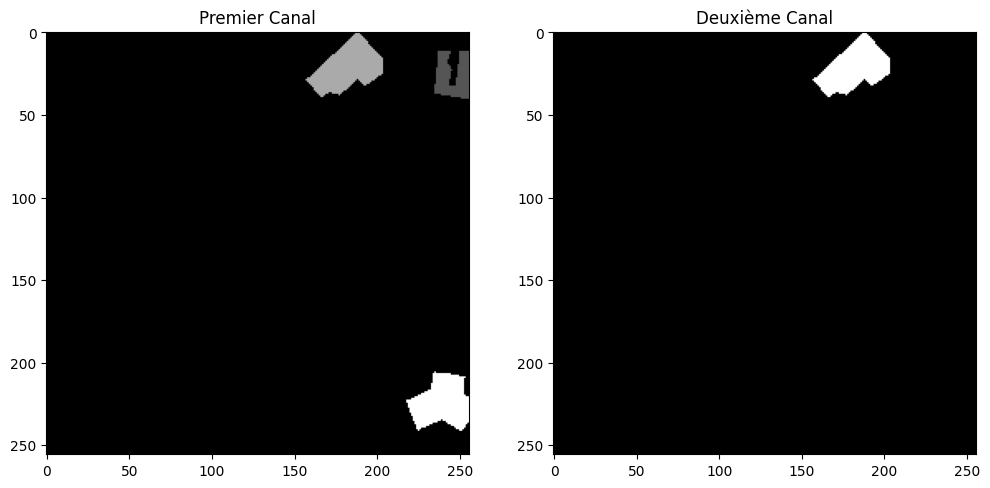

In [ ]:
import matplotlib.pyplot as plt
from skimage import io

# Chargez votre masque (en supposant qu'il a deux canaux)
mask_path = '/content/drive/MyDrive/building_detect_1/data_4/train/masks/000000025.tif'
mask = io.imread(mask_path)

# Vérifiez le nombre de canaux
if mask.ndim == 3 and mask.shape[2] > 1:
    # Affichage du premier canal
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(mask[:, :, 0], cmap='gray')
    plt.title('Premier Canal')

    # Affichage du deuxième canal
    plt.subplot(1, 2, 2)
    plt.imshow(mask[:, :, 1], cmap='gray')
    plt.title('Deuxième Canal')

    plt.show()
else:
    print("Le masque n'a pas deux canaux.")


In [ ]:
import numpy as np

unique_values = np.unique(y_train)
print("Valeurs uniques dans les masques d'entraînement :", unique_values)

unique_values_test = np.unique(y_test)
print("Valeurs uniques dans les masques de test :", unique_values_test)


Valeurs uniques dans les masques d'entraînement : [0 1]
Valeurs uniques dans les masques de test : [0 1]
